In [17]:
from pyuul import VolumeMaker # the main PyUUL module
from pyuul import utils # the PyUUL utility module
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# 使用pyuul解析文件，获取数据
coords, atname = utils.parsePDB('em_full.pdb')
atoms_channel = utils.atomlistToChannels(atname) # calculates the corresponding channel of each atom
radius = utils.atomlistToRadius(atname) # calculates the radius of each atom

In [19]:
# 指定设备类型，pyuul给了三种VolumeMaker形式
device = "cpu" # runs the volumes on CPU. use "cuda" for GPU. Pytorch needs to be installed with cuda support in this case.
VoxelsObject = VolumeMaker.Voxels(device=device,sparse=True)
PointCloudSurfaceObject = VolumeMaker.PointCloudVolume(device=device)
PointCloudVolumeObject = VolumeMaker.PointCloudSurface(device=device)

In [20]:
# 指定数据的device，查看数据维度
coords = coords.to(device) # ( batch, numberOfAtoms, 3 )
radius = radius.to(device) # ( batch, numberOfAtoms )
atoms_channel = atoms_channel.to(device) # ( batch, numberOfAtoms )
coords.shape, radius.shape, atoms_channel.shape

(torch.Size([1, 1117, 3]), torch.Size([1, 1117]), torch.Size([1, 1117]))

In [21]:
# 获取体素数据，形状为( batch, channels, x,y,z)
VoxelRepresentation = VoxelsObject(coords, radius, atoms_channel, resolution=8).to_dense()
VoxelRepresentation.shape

torch.Size([1, 6, 22, 21, 22])

/tmp/ipykernel_64939/1914644902.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


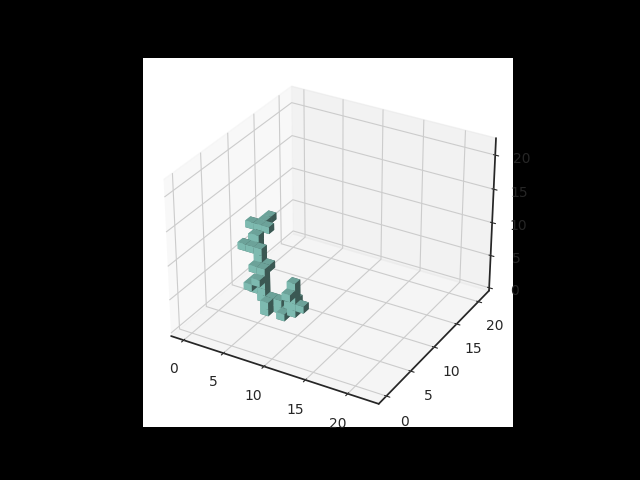

In [22]:
# 画体素数据
from turtle import pd

ax = plt.figure().add_subplot(1, 1, 1,projection='3d')
# 将所有通道加起来进行判断，体素每个位置的通道总和的值来判断是否要显示当前的位置
voxels = VoxelRepresentation.sum(1) > 0.5
ax.voxels(voxels[0])

#绘图风格的方法点击左侧运行/右侧运行+向下箭头
plt.style.use('seaborn-white') 

plt.show()


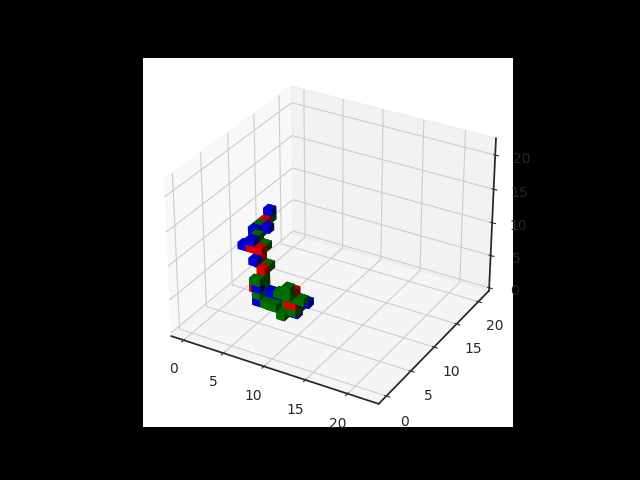

In [23]:
# 给元素赋值的方式，根据值的大小来赋予元素，例如 v>0为红色，v>0.1绿色，v>0.5红色
colors = np.empty(VoxelRepresentation[0][1].shape, dtype=object)
colors[VoxelRepresentation[0][1]>0] = 'blue'
colors[VoxelRepresentation[0][1]>0.1] = 'green'
colors[VoxelRepresentation[0][1]>0.5] = 'red'
colors[VoxelRepresentation[0][1]>1] = 'yellow'

ax = plt.figure().add_subplot(1, 1, 1,projection='3d')
# voxels = VoxelRepresentation.sum(1) > 0.5
ax.voxels(VoxelRepresentation[0][1]>0.05, facecolors=colors)
plt.show()

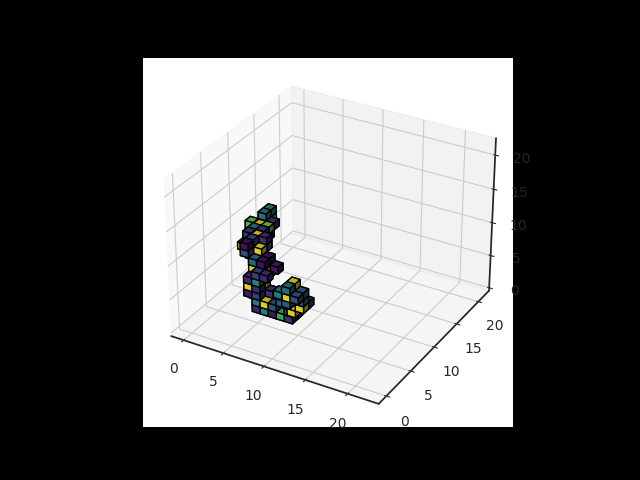

In [24]:
# 所有通道总和体素数据
voxels = VoxelRepresentation.sum(1)[0]

# 定义颜色映射
cmap = 'viridis'
# 创建图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# 绘制3D图像，根据综合体素数据具体的值来变化颜色
voxels = ax.voxels(voxels>0.05, facecolors=plt.cm.viridis(voxels), edgecolor='k')
plt.show()

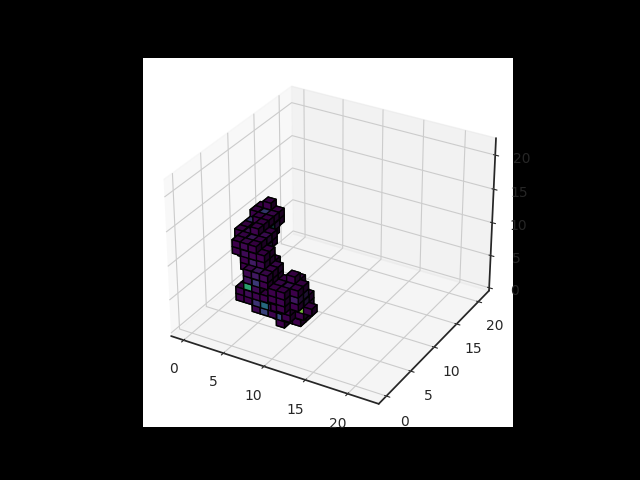

In [25]:
# 显示单个通道的体素
voxels = VoxelRepresentation[0][0]

# 定义颜色映射
cmap = 'viridis'
# 创建图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# 绘制3D图像
voxels = ax.voxels(voxels>0, facecolors=plt.cm.viridis(voxels), edgecolor='k')

plt.show()

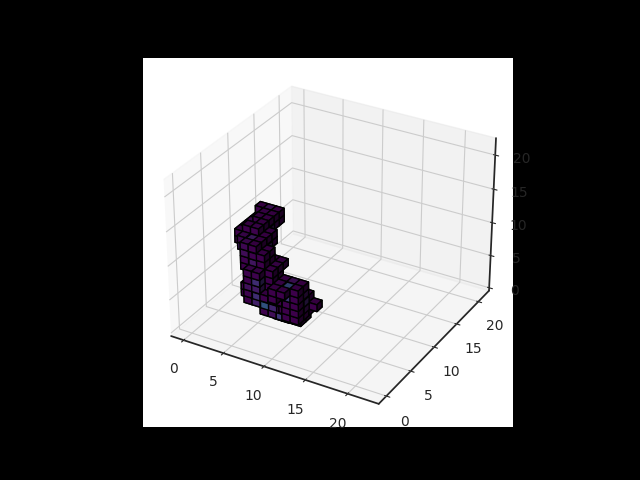

In [26]:
voxels = VoxelRepresentation[0][1]

# 定义颜色映射
cmap = 'viridis'

# 创建图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制3D图像
ax.voxels(voxels>0, facecolors=plt.cm.viridis(voxels), edgecolor='k')

# 添加颜色条
# plt.colorbar(voxels, ax=ax, shrink=0.5)

plt.show()

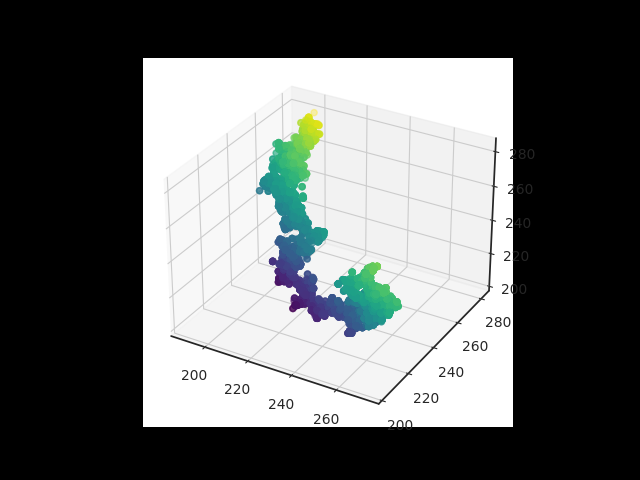

In [27]:
# 获取表面点云数据
SurfacePoitCloud = PointCloudSurfaceObject(coords, radius)

point_cloud = SurfacePoitCloud[0]
# 创建数据
x = point_cloud[:,0]
y = point_cloud[:,1]
z = point_cloud[:,2]

# 创建3D图形对象
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制点云表面数据
ax.scatter(x, y, z, c=point_cloud.sum(-1), cmap=cmap)

# 显示图形
plt.show()

/tmp/ipykernel_64939/641581006.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, c=colors, cmap=cmap)


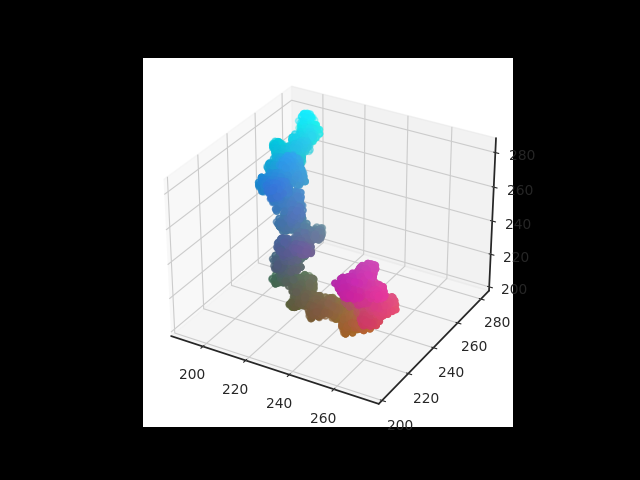

In [28]:
# 获取体素点云数据
VolumePoitCloud = PointCloudVolumeObject(coords, radius)
# 创建数据
x = VolumePoitCloud[:,0]
y = VolumePoitCloud[:,1]
z = VolumePoitCloud[:,2]

# 颜色的值需要缩放到 [0，1) 之间。这里需要对颜色进行缩放处理
colors = (VolumePoitCloud - VolumePoitCloud.min()) / (VolumePoitCloud.max() - VolumePoitCloud.min())

# 创建3D图形对象
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制点云表面数据
ax.scatter(x, y, z, c=colors, cmap=cmap)

# 显示图形
plt.show()

In [31]:
import open3d as o3d

# 创建 Open3D 点云对象
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(VolumePoitCloud)

# 保存点云数据到PCD文件
o3d.io.write_point_cloud("1.xyz", point_cloud)

True